# Fetch Publications for an author

In [33]:
import pycountry
import pandas as pd
import requests
import xmltodict

# Read the Stanford 2% ranking excel file
df = pd.read_excel('Table_1_Authors_career_2022_pubs_since_1788_wopp_extracted_202310.xlsx', sheet_name='Data', engine='openpyxl')
# We are only considering the Computer Science subject for this study
df = df.loc[df['sm-field'] == 'Information & Communication Technologies']
# A mapping between Stanford's top 2% ranking `sm-field` and Scopus API `SUBJECTAREA`
subject_areas_mapping = {
    'Information & Communication Technologies': ['COMP', 'MULT']
}

# Set up your Scopus API key
api_key = '5aa908d24ec7e71ef0cf68cb3bff134d'

# Define the Scopus API endpoint for author search
scopus_search_url = 'https://api.elsevier.com/content/search/author'

# Define the Scopus API endpoint for retrieving author's publications
scopus_search_publications_url = 'https://api.elsevier.com/content/search/scopus'

# Define the Scopus Abstract Retrieval API to get detailed information about the publication
scopus_abstract_url = f'https://api.elsevier.com/content/abstract/eid'

# Set up headers with your API key
headers = {
    'X-ELS-APIKey': api_key,
}

# Utility methods
def get_author_names(author_full_name):
    # Split the full name into first and last names
    names = author_full_name.split(', ', 1)
    first_name = names[-1]
    last_name = names[0] if len(names)==2 else ''
    return first_name, last_name

def get_country_name(country_code):
    try:
        country_name = pycountry.countries.get(alpha_3=country_code).name
        return country_name
    except AttributeError:
        # Handle cases where the country code is not found
        return ''

In [110]:
# Function to search for an author in Scopus using name, affiliation, country, and field
def search_author(author_name, affiliation, country_code, field):
    first_name, last_name = get_author_names(author_name)
    subject_areas = subject_areas_mapping.get(field, [])
    country_name = get_country_name(country_code)

    query = f'AUTHLASTNAME({last_name}) AND AUTHFIRST({first_name}) AND {" OR ".join(map(lambda s: f"SUBJAREA({s})", subject_areas))}'
    response = requests.get(scopus_search_url, params={'query': query, 'count': 200}, headers=headers)

    if response.status_code == 200:
        results = response.json().get('search-results', {}).get('entry', [])
        results.sort(key=lambda x: x.get('document-count', 0), reverse=True)
        results.sort(key=lambda x: x.get('affiliation-current', {}).get('affiliation-country', '') == country_name, reverse=True)
        results.sort(key=lambda x: x.get('affiliation-current', {}).get('affiliation-name', '') == affiliation, reverse=True)
        return results[0] if results else None
    else:
        return None

In [ ]:
# Function to fetch all publications for an author using Scopus Author ID
def fetch_author_publications(author_id, publications=None, start_index=0):
    if not publications:
        publications = []

    query = f'AU-ID({author_id})'
    response = requests.get(scopus_search_publications_url, params={'query': query, 'start': start_index, 'count': 200}, headers=headers)

    if response.status_code == 200:
        search_results = response.json().get('search-results', {}).get('entry', [])

        for entry in search_results:

            # Retrieve co-author details if any citations for the publication else default to empty list because costly operation
            if entry.get('citedby-count', 0) > 0:
                abstract_url = f'{scopus_abstract_url}/{entry.get("eid", "")}'
                response_abstract = requests.get(abstract_url, headers=headers)
                if response_abstract.status_code == 200:
                    author_data = xmltodict.parse(response_abstract.text).get('abstracts-retrieval-response', {}).get('authors', []).get('author', [])
                    if not isinstance(author_data, list): # If only one author
                        author_data = [author_data]
                    authors = map(lambda a: {
                            'scopus_id': a['@auid'],
                            'name': a.get('ce:indexed-name', ''),
                        }, author_data)
                else:
                    authors = []

            publication_data = {
                'title': entry.get('dc:title', ''),
                'eid': entry.get('eid', ''),
                'citations': entry.get('citedby-count', 0),
                'authors': list(authors),
                'publication_name': entry.get('prism:publicationName', ''),
                'issn': entry.get('prism:issn', ''),
                'cover_date': entry.get('prism:coverDate', ''),
                'venue': entry.get('prism:aggregationType', ''),
                'volume': entry.get('prism:volume', ''),
                'issue': entry.get('prism:issueIdentifier', ''),
                'page_range': entry.get('prism:pageRange', ''),
                'doi': entry.get('prism:doi', ''),
            }
            publications.append(publication_data)

        # Fetch the next set of publications if available
        start_index += len(search_results)
        if start_index < int(response.json().get('search-results', {}).get('opensearch:totalResults', 0)):
            return fetch_author_publications(author_id, publications, start_index)

    return publications

In [112]:
scopus_results = []

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():

    author_name = row['authfull']
    affiliation = row['inst_name']
    country_code = row['cntry']
    field = row['sm-field']
    print(author_name)

    # Search for the author in Scopus
    author_search_result = search_author(author_name, affiliation, country_code, field)

    # Process the search result as needed
    if author_search_result is not None:
        author_id = author_search_result.get('dc:identifier', '').split(':')[-1]
        author_publications = fetch_author_publications(author_id)
        scopus_results.append({
            'scopus_id': author_id,
            'name': author_name,
            'publications': author_publications
        })
        if len(scopus_results) == 10:
            break
    else:
        print(f"Author not found for: {author_name}, Affiliation: {affiliation}, Country: {country_code}, Field: {field}")

# Find the remaining usage-limit for Scopus API


Zadeh, Lotfi A.
Hinton, Geoffrey
Jain, Anil
Bengio, Yoshua
Donoho, David
Yager, Ronald R.
Xu, Zeshui
van der Aalst, Wil M.P.
Deb, Kalyanmoy
Lowe, David G.


In [114]:
import json
with open('top_10_CS_researcher_all_publications.json', 'w') as fp:
    json.dump(scopus_results, fp)

odict_keys(['@xmlns', '@xmlns:dn', '@xmlns:ait', '@xmlns:ce', '@xmlns:cto', '@xmlns:dc', '@xmlns:prism', '@xmlns:xocs', '@xmlns:xsi', 'coredata', 'affiliation', 'authors', 'language', 'authkeywords', 'idxterms', 'subject-areas', 'item'])

# Calculate Metrics for the Author

In [1]:
import json
with open('top_10_CS_researcher_all_publications.json', 'r') as fp:
    authors = json.load(fp)

In [104]:
import pandas as pd
from calculate import *

rows = []
for author in authors:
    if author['name'] in ['Jain, Anil', 'Xu, Zeshui']: continue
    rows.append({
        'Name': author['name'],
        'Publications': len(author['publications']),
        'Citations': total_citations(author['publications']),
        'h-index': h_index(author['publications']),
        'h-frac-index': h_frac_index(author['publications']),
        'hm-index': hm_index(author['publications']),
        'h-leadership-index': h_leadership_index(author['scopus_id'], author['publications']),
        # 'i10-index'
        # 'Average Citations per Paper',
        # 'Average number of Authors',
        # 'Authorship position distribution',
    })


df = pd.DataFrame(rows)


In [105]:
df

,Name,Publications,Citations,h-index,h-frac-index,hm-index,h-leadership-index
0,"Zadeh, Lotfi A.",268,138014,63,42,199,63
1,"Hinton, Geoffrey",265,389243,111,49,114,110
2,"Bengio, Yoshua",551,359328,146,41,149,145
3,"Donoho, David",203,100027,86,56,86,84
4,"Yager, Ronald R.",886,55487,100,46,612,99
5,"van der Aalst, Wil M.P.",977,60458,118,16,366,116
6,"Deb, Kalyanmoy",644,85064,87,34,236,85
7,"Lowe, David G.",87,77999,40,28,40,40


* We chose to assign weights based on a normalised inverse gaussian curve
* Since the center of the normalise inverse gaussian curve can be zero, we chose to exclude the region.

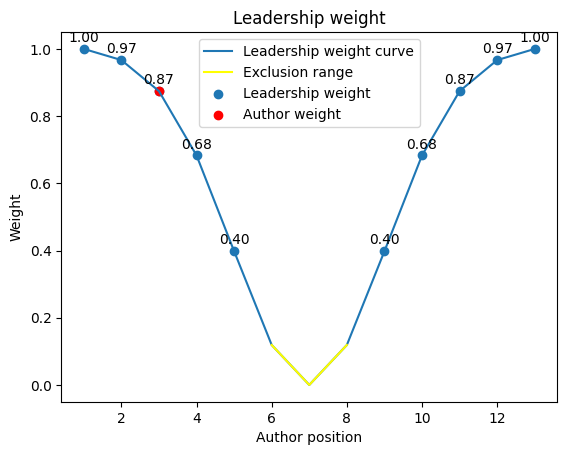

In [113]:
plot_leadership_weight(2, 10, annotate=True)

### Problem
* For a particular position, the increase in authors should lead to a decrease in weight but the opposite is happening.
* This is because the authorship positions are spread linearly across the inverse gaussian curve so an increase of authors leads one position to move closer to the edges.
* Right now, the normalisation is implemented so that the first and last authors have a weight of 1.
```
Authors Position Weight
2       2        1.0
3       2        0.77
4       2        0.87
5       2        0.90
6       2        0.93
```
How to solve this problem?
Maybe by not linearly distributing the authorship position across the gaussian distribution but moving it logarithmically closer to the center

In [130]:
def plot_leadership_weight2(author_position, n=1, mean=0, std_dev=1, annotate=False):
    # Logarithmically reduce the weights based on the author's position
    author_positions = np.arange(0, n)
    author_positions_reindexed = np.array([author_position if author_position <= n/2 else n-author_position-1 for author_position in author_positions])
    author_weights = 1/(1+np.log(1+author_positions_reindexed))

    plt.plot(author_positions+1, author_weights, label='Leadership weight curve')

    # Plot all authors' weights
    plt.scatter(author_positions+1, author_weights, label='Leadership weight')
    if annotate:
        for x, y in zip(author_positions+1, author_weights):
            plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,5), ha='center')

    plt.scatter(author_position+1, author_weights[author_position], label='Author weight', color='red')
    plt.xlabel('Author position')
    plt.ylabel('Weight')
    plt.title('Leadership weight')
    plt.legend()
    plt.show()

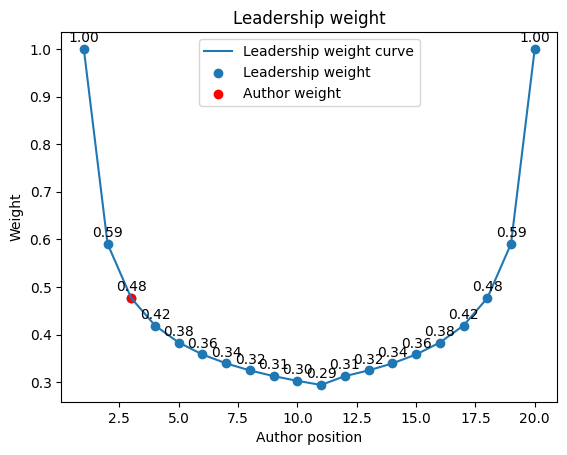

In [135]:
plot_leadership_weight2(2, 20, annotate=True)

### Advantages of logarithmic approach over inverse gaussian approach
* fixes increasing author weight problem due to increasing number of authors for a fixed position

### Disadvantages
* Too big a drop between first and second author positions
* An author's position fixes their weight, the number of authors do not contribute

### Aim: When determining ranking
* Account number of authors
* Account position of author

/tmp/ipykernel_235629/2933082444.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf